In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard
import os
import datetime
from sklearn.preprocessing import StandardScaler
import re
from tensorflow.keras.layers import Dropout

%load_ext tensorboard

<h2> Data pre-processing </h2>

In [2]:
def drop_columns(dataframe):
    return dataframe.drop(['PassengerId', 'Ticket'], axis=1)

In [3]:
def group_name_columns(dataframe):
    
    dataframe['Title'] = dataframe.Name.str.extract(' ([A-Za-z]+)\.', expand = False)
    df_dropped = dataframe.drop('Name', axis=1)

    Title_Dictionary = {
            "Capt":       "Officer",
            "Col":        "Officer",
            "Major":      "Officer",
            "Dr":         "Dr",
            "Rev":        "Officer",
            "Jonkheer":   "Royalty",
            "Don":        "Royalty",
            "Sir" :       "Royalty",
            "the Countess":"Royalty",
            "Dona":       "Royalty",
            "Lady" :      "Royalty",
            "Mme":        "Mrs",
            "Ms":         "Mrs",
            "Mrs" :       "Mrs",
            "Mlle":       "Miss",
            "Miss" :      "Miss",
            "Mr" :        "Mr",
            "Master" :    "Master"
                       }
    
    dataframe['Title'] = dataframe.Title.map(Title_Dictionary)
    
    name_one_hot = pd.get_dummies(dataframe['Title'], prefix='Title')
    dataframe = dataframe.drop('Title', axis=1)
    dataframe = dataframe.drop('Name', axis=1)
    dataframe = dataframe.join(name_one_hot)
    
    return dataframe

In [4]:
def embarked_column(dataframe):

    dataframe["Embarked"] = dataframe["Embarked"].fillna(value="Q")
    
    embarked_one_hot = pd.get_dummies(dataframe['Embarked'], prefix='Embarked')
    dataframe = dataframe.drop('Embarked', axis=1)
    dataframe = dataframe.join(embarked_one_hot)
    
    return dataframe

In [5]:
def fix_cabin_column(dataframe, is_train):
    
    dataframe['Cabin'] = dataframe['Cabin'].fillna('U')
    dataframe['Cabin'] = dataframe['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    
    if is_train == False:
        dataframe['Cabin_T'] = 0
    
    # hot-encode cabins
    cabin_one_hot = pd.get_dummies(dataframe['Cabin'], prefix='Cabin')
    dataframe = dataframe.drop('Cabin', axis=1)
    dataframe = dataframe.join(cabin_one_hot)
    
    return dataframe

In [7]:
def fix_missing_values(dataframe):
    
    column = ['Pclass','Sex','Embarked','SibSp','Parch']
    for value in range(len(column), 0, -1):
        dataframe['Age'] = dataframe['Age'].fillna(dataframe.groupby(column[0:value])['Age'].transform('mean'))
        dataframe['Fare'] = dataframe['Fare'].fillna(dataframe.groupby(column[0:value])['Fare'].transform('mean'))

    return dataframe

In [8]:
def hotencode_sex_column(dataframe):
    
    dataframe['Sex'] = dataframe['Sex'].map({'female': 1, 'male': 0}).astype(int)
    
    return dataframe


In [9]:
def scale_date_train(dataframe):
    
    x = np.asarray(dataframe.drop('Survived', axis=1), dtype=float)
    scale = StandardScaler()
    x_values = scale.fit_transform(x)
    y_label = dataframe["Survived"].values
    return x_values, y_label
    
def scale_date_test(dataframe):
    

    x = np.asarray(dataframe, dtype=float)
    scale = StandardScaler()
    x_values = scale.fit_transform(x)
    return x_values

<h2> For Training Data </h2>

In [10]:
df_train = pd.read_csv("train.csv")

df_dropped_column = drop_columns(df_train)

df_fixed_columns = fix_missing_values(df_dropped_column)

df_cleaned_names = group_name_columns(df_fixed_columns)

df_embark_columns = embarked_column(df_cleaned_names)
df_cabin_columns = fix_cabin_column(df_embark_columns, is_train= True)

df_hotencode_sex_columns = hotencode_sex_column(df_cabin_columns)

x_train, y_train= scale_date_train(df_hotencode_sex_columns)

<h2> For Test Data </h2>

In [11]:
df_test = pd.read_csv("test_survi.csv")
df_test_cleaned = df_test.drop('Survived', axis=1)

y_test= df_test["Survived"].values

df_dropped_column = drop_columns(df_test_cleaned)

df_fixed_columns = fix_missing_values(df_dropped_column)

df_cleaned_names = group_name_columns(df_fixed_columns)

df_embark_columns = embarked_column(df_cleaned_names)
df_cabin_columns = fix_cabin_column(df_embark_columns, is_train= False)

df_hotencode_sex_columns = hotencode_sex_column(df_cabin_columns)

x_test= scale_date_test(df_hotencode_sex_columns)

<h2> Random Forest Models</h2>

In [12]:
# Check with real data
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier(random_state=0, n_estimators=50, max_depth=10, max_features=6, n_jobs=-1)

randomForest.fit(x_train, y_train)

y_pred = randomForest.predict(x_test)

print(f"Train Score is {randomForest.score(x_train, y_train)}, Test Score is {accuracy_score(y_test, y_pred)}")

Train Score is 0.9214365881032548, Test Score is 0.777511961722488


<h2> Keras Models on clean training data</h2>

In [13]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

model = Sequential([
    Dense(24, activation="relu"),#, input_shape=(24,)),
    Dropout(0.5),
    Dense(1, activation="sigmoid")

])

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


history = model.fit(x_train, 
          y_train, 
          validation_data=(x_test, y_test),
          epochs=100,
          callbacks=[tensorboard_callback],
         )

print(f"Train Score is {model.evaluate(x_train, y_train)[1]},Test Score is {model.evaluate(x_test, y_test)[1]}")


#Train Score is 0.857463538646698,Test Score is 0.760765552520752

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 891 samples, validate on 418 samples
Epoch 1/100
891/891 [==============================] - 0s 420us/sample - loss: 0.7122 - acc: 0.6588 - val_loss: 0.6246 - val_acc: 0.7225
Epoch 2/100
891/891 [==============================] - 0s 100us/sample - loss: 0.6585 - acc: 0.7015 - val_loss: 0.5827 - val_acc: 0.7249
Epoch 3/100
891/891 [==============================] - 0s 98us/sample - loss: 0.6005 - acc: 0.7363 - val_loss: 0.5540 - val_acc: 0.7536
Epoch 4/100
891/891 [==============================] - 0s 100us/sample - loss: 0.5566 - acc: 0.7475 - val_loss: 0.5387 - val_acc: 0.7632
Epoch 5/100
891/891 [==============================] - 0s 100us/sample - loss: 0.5447 - acc: 0.7553 - val_loss: 0.5252 - val_acc: 0.7679
Epoch 6/100
891/891 [==============================] - 0s 104us/sample - loss: 0.5472 - acc: 0.

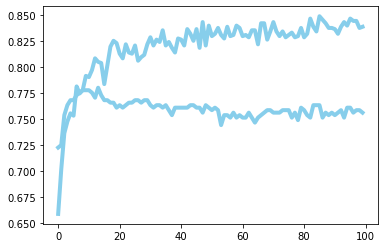

In [14]:
import matplotlib.pyplot as plt
acc = history.history["acc"]
val_acc = history.history["val_acc"]

x = range(0,100)

plt.plot( x, val_acc, markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( x, acc, markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)